In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import fastai
import fastai.vision
import time, copy
import core

# Neural Splicing

Transfer learning has seen much success in the field of computer vision and more recently natural language processing. Specific approaches vary considerably, here we focus on extending a commonly used technique in which some of the weights and biases of a pre-trained model are loaded into a new architecture which is repurposed to some new tasks. This method has long since seen success in computer vision tasks and more recently in the field of natural language processing, popularized by Jeremy Howard and Sebastian Ruder in their paper introducing [ULMFiT ](https://arxiv.org/abs/1801.06146) and in Jeremy's [courses at fast.ai](https://course.fast.ai/) and later extended upon by folks at [google](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) (adding bidirectionality) and [open.ai](https://blog.openai.com/language-unsupervised/) (replacing LSTM core with a transformer), altogether resulting in many state-of-the-art NLP results.

Broadly speaking, this approach can be thought of as viewing a pretrained model as being composed of two pieces: a general-purpose *body* or *core* and a task-specific *head*. Thus far, applications of this approach involve replacing an existing *head* with a new one tailored for a specific task. Typically, in CV/NLP the core consists of the convolutional/recurrent components respectively, whereas the head is consist of pooling/flattening layers followed by a shallow multi-layer perceptron.

Here we investigate the question: why is in each of these cases the new component is added only **on top of** existing components? Can anything be gained by **splicing new components directly into the core architecture**?

Let us illustrate witha concrete example: suppose we has trained the following MLP for some regression task:

`
m = (nn.Sequential(nn.Linear(2,5), 
                   nn.ReLU(), 
                   nn.Linear(5,9), 
                   nn.ReLU(), 
                   nn.Linear(9,1)))
`

and one would like to add a layer *between* the first and second linear layer:

`
m_splice = (nn.Sequential(nn.Linear(2,5), 
                          nn.ReLU(), 
                          nn.Linear(5,5),      #Additional, un-trained component
                          nn.ReLU(), 
                          nn.Linear(5,9), 
                          nn.ReLU(), 
                          nn.Linear(9,1)))
`

Some observations: if the weights of the newly introduced layer are initialized randomly, then we can be certain that model performance will collapse. Since the original layers were trained together, layer two (nn.Linear(5,9)) *expects* inputs to look a certain way, (e.g look like something layer one would have output). Essentially this degradation would be the result of an extreme case of covariate shift which would defeat the purpose of using the pre-trained weights.

On the other hand, if we initialize the bias to zero and the weights to identity matrix, then the new layer has *no effect* on the model initially. Then if we freeze the learning rate on all the original layers, we can think of learning the weights of our new component as learning a post-processing of layer one output to be more 'palatable' for the rest of the network to consume in a similar spirit as batch-norm is introduced to post-process the output of layers to have desirable sample statistics. In practice, we anneal the learning rate on the layers surrounding the splice gradually from zero to some stable level while annealing the learning rate on the spliced component along a one cycle schedule as introduced [here](https://arxiv.org/abs/1708.07120). By monitoring gradient norms through the added component(s) as well as the original layers, one can propose a metric for determining the extent to which the architecture has 'accepted' or 'rejected' the new components. 

In this repo, we focus for now on convolutional and linear splicing and postpone experiments with splicing into recurrent architectures to a later date. Specifically, we are interested in exploring the following questions:

1) If we begin by training an architecture (A1) to some stop criterion (where reduction in loss is minimal, over overfitting begins to occur, etc.) and then splice in components to achieve architecture (A2), are we able to train (A2) further to achieve an overall lower loss (or else better performance by some specified metric)? 

2) Consider fully trained architecture (A2) above, along with full training history (pre- and post- splice, beginning from scratch). Make a copy of the architecture denoted (B2) and re-initialize weights randomly and train (B2) from scratch. We are interested:
* Does (B2) achieve worse, the same, or better *ultimate* performance (with a pre-defined stopping criterion specified a priori) as compared to (A2)
* How does the complete training history of (A2*) compare to that of (A2)? 
        
       
An affirmative response to question (1) suggests a cheap, fast procedure for incrementally increasing a trained model's performance if slight increase in performance is necessary for an application. 

A positive response to question (2) suggests alternative paradigms for training deep neural networks, rather than initializing a very deep network completely at random, perhaps it is faster, more efficient, or ultimately result in a better performance if one begins with a shallower network and gradually adds depth, splicing in layers over time and training them gradually. 

## Loading  data

We make use of fastai easy-to-use data block API for loading one of several common datasets to test our approach. 

In [2]:
""" Loading the MNIST dataset...
url = fastai.datasets.URLs.MNIST
path = fastai.datasets.untar_data(url)
data = fastai.vision.ImageDataBunch.from_folder(path, train='training', valid='testing')
learn = fastai.vision.create_cnn(data, models.resnet18, metrics=accuracy)
"""

" Loading the MNIST dataset...\nurl = fastai.datasets.URLs.MNIST\npath = fastai.datasets.untar_data(url)\ndata = fastai.vision.ImageDataBunch.from_folder(path, train='training', valid='testing')\nlearn = fastai.vision.create_cnn(data, models.resnet18, metrics=accuracy)\n"

In [3]:
""" Loading the CIFAR dataset...
url = fastai.datasets.URLs.CIFAR
path = fastai.datasets.untar_data(url)
data = (fastai.vision.ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(fastai.vision.get_transforms(), size=224)
        .databunch(bs=64))
"""

" Loading the CIFAR dataset...\nurl = fastai.datasets.URLs.CIFAR\npath = fastai.datasets.untar_data(url)\ndata = (fastai.vision.ImageItemList.from_folder(path)\n        .split_by_folder(train='train', valid='test')\n        .label_from_folder()\n        .transform(fastai.vision.get_transforms(), size=224)\n        .databunch(bs=64))\n"

In [4]:
"""  Loading the PETS dataset ... 
func = lambda x: str(x)[46:].rstrip('.jpg1234567890').rstrip('_')
url = fastai.datasets.URLs.PETS
path = fastai.datasets.untar_data(url)
data = (fastai.vision.ImageItemList.from_folder(path/'images')
        .random_split_by_pct()
        .label_from_func(func)
        .transform(fastai.vision.get_transforms(), size=224)
        .databunch(bs=64))
"""

"  Loading the PETS dataset ... \nfunc = lambda x: str(x)[46:].rstrip('.jpg1234567890').rstrip('_')\nurl = fastai.datasets.URLs.PETS\npath = fastai.datasets.untar_data(url)\ndata = (fastai.vision.ImageItemList.from_folder(path/'images')\n        .random_split_by_pct()\n        .label_from_func(func)\n        .transform(fastai.vision.get_transforms(), size=224)\n        .databunch(bs=64))\n"

In [2]:
url = fastai.datasets.URLs.CIFAR
path = fastai.datasets.untar_data(url)
data = (fastai.vision.ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(fastai.vision.get_transforms(), size=112)
        .databunch(bs=64))

## Fastai benchmark

While we're here might as well check out how fast.ai does on this task just to see how we're going along. You'll  notice how easy to use their API is (if you haven't checked it out yet, I highly recommend taking a look!) 

In [3]:
learn = fastai.basic_train.Learner(data=data, model=core.cnn(nc=data.c), loss_func=nn.CrossEntropyLoss(), metrics=fastai.metrics.accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


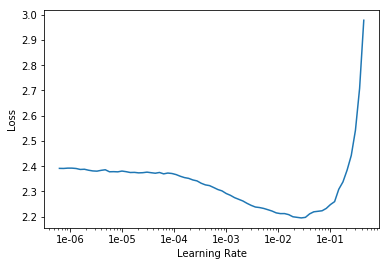

In [4]:
learn.lr_find(); learn.recorder.plot()

In [5]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.443483,1.451396,0.480000
2,1.095327,1.022746,0.638000
3,0.885394,0.763966,0.734100
4,0.786304,0.688436,0.756300


## Set up 
Feel free to check out /.core for implementation details...

In [6]:
dls = {'train':data.train_dl, 'val':data.valid_dl}
model = core.cnn(nc=data.c).cuda() ; model.init_opts()
crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

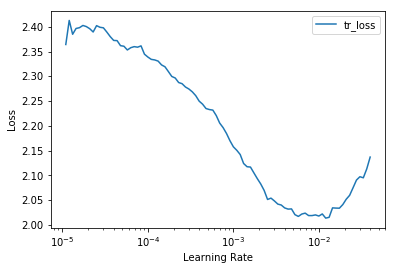

In [7]:
lrf = core.LearningRateFinder(opt, nits=100, min_lr=1e-5, max_lr=1e-1)
lrf.lr_find(model, data.train_dl, crit)

In [8]:
model.fit(crit, dls, num_epochs=4)

Epoch 1/4
----------
train Loss: 2.0697 Acc: 0.2842
val Loss: 1.4646 Acc: 0.4616
Epoch 2/4
----------
train Loss: 1.4127 Acc: 0.4874
val Loss: 1.0991 Acc: 0.6070
Epoch 3/4
----------
train Loss: 1.1396 Acc: 0.5928
val Loss: 0.9245 Acc: 0.6723
Epoch 4/4
----------
train Loss: 1.0214 Acc: 0.6342
val Loss: 0.8825 Acc: 0.6921
00:04:39


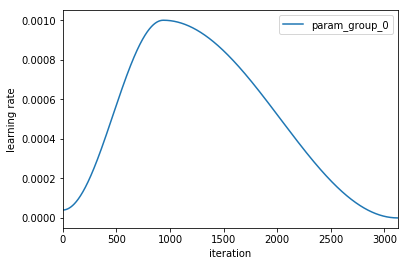

In [9]:
model.plot_lr()

In [10]:
model.splice()

In [11]:
model.fit(crit, dls, num_epochs=4)

Epoch 1/4
----------
train Loss: 1.0251 Acc: 0.6330
val Loss: 0.8911 Acc: 0.6828
Epoch 2/4
----------
train Loss: 0.9893 Acc: 0.6491
val Loss: 0.8634 Acc: 0.6993
Epoch 3/4
----------
train Loss: 0.9562 Acc: 0.6612
val Loss: 0.8176 Acc: 0.7123
Epoch 4/4
----------
train Loss: 0.9077 Acc: 0.6787
val Loss: 0.7704 Acc: 0.7288
00:06:08


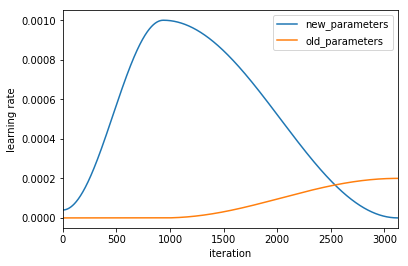

In [12]:
model.plot_lr()

In [13]:
model.init_opts()

In [14]:
model.fit(crit, dls, num_epochs=4)

Epoch 1/4
----------
train Loss: 0.8908 Acc: 0.6868
val Loss: 0.8199 Acc: 0.7112
Epoch 2/4
----------
train Loss: 0.8720 Acc: 0.6948
val Loss: 0.7282 Acc: 0.7447
Epoch 3/4
----------
train Loss: 0.7730 Acc: 0.7289
val Loss: 0.6163 Acc: 0.7850
Epoch 4/4
----------
train Loss: 0.6820 Acc: 0.7625
val Loss: 0.5815 Acc: 0.7994
00:06:22


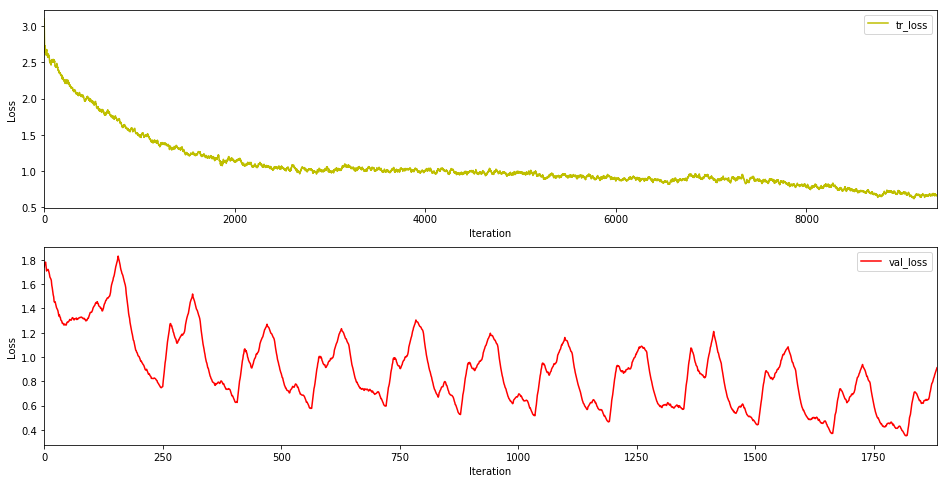

In [15]:
model.plot_history()